In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [5]:
BASE_DIR = '../input/utkface-new/UTKFace/'

In [6]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [7]:
#convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


In [8]:
#map labels for gender
gender_dict = {0:'Male', 1:'Female'}

**Exploratory Data Analysis**

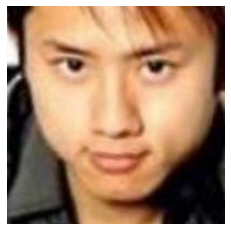

In [12]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

<AxesSubplot:xlabel='age', ylabel='Density'>

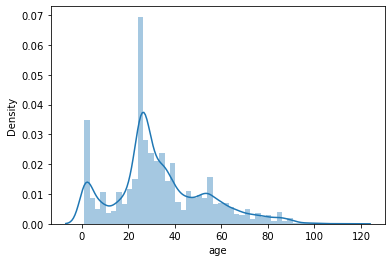

In [13]:
sns.distplot(df['age'])

<AxesSubplot:xlabel='gender', ylabel='count'>

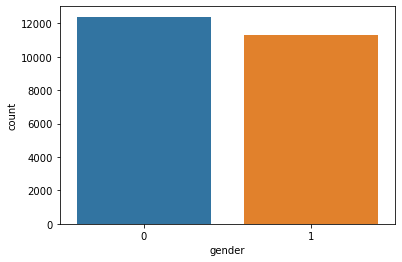

In [14]:
sns.countplot(df['gender'])

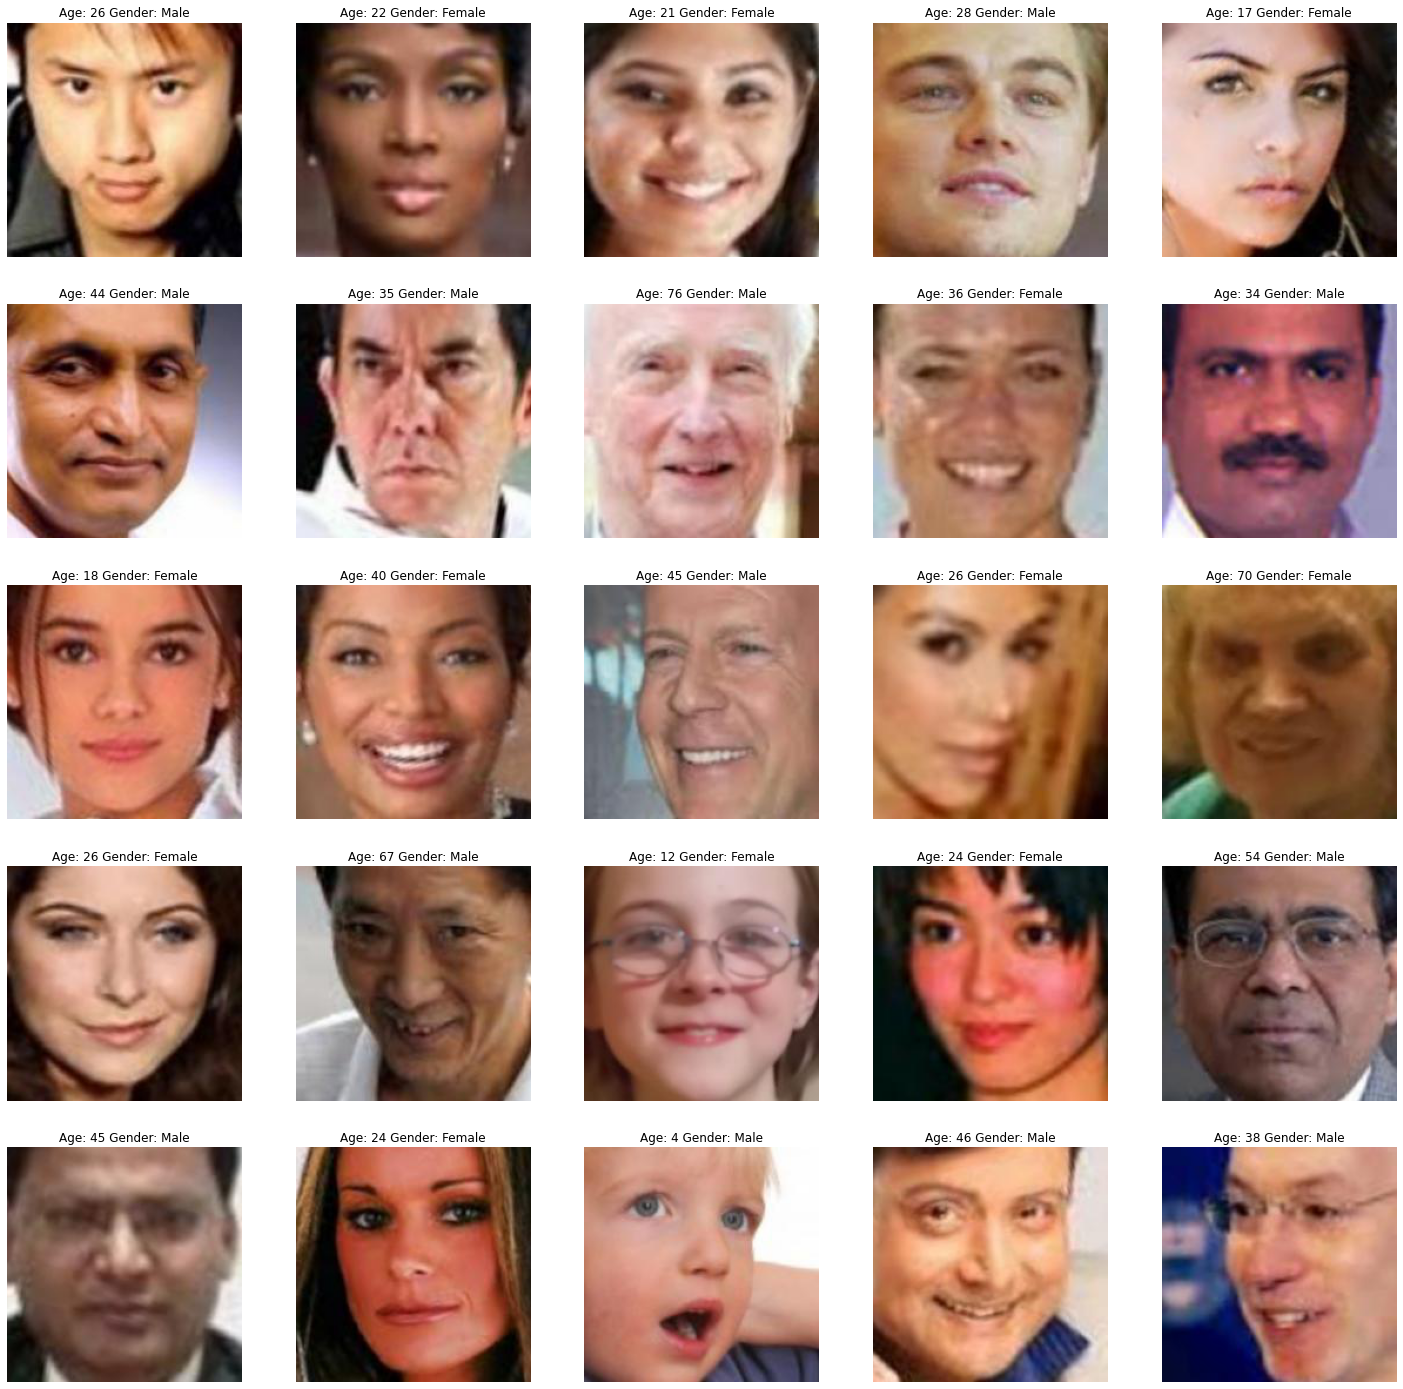

In [15]:
#to display grid of images
plt.figure(figsize=(25, 25))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

**Feature Extraction**

In [16]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    #ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [17]:
x = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [18]:
x.shape

(23708, 128, 128, 1)

In [19]:
# normalize the images
x = x/255.0

In [21]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [22]:
input_shape = (128, 128, 1)


**Model Creation**

In [23]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

2023-01-29 14:45:53.717200: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 63, 63, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 61, 61, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

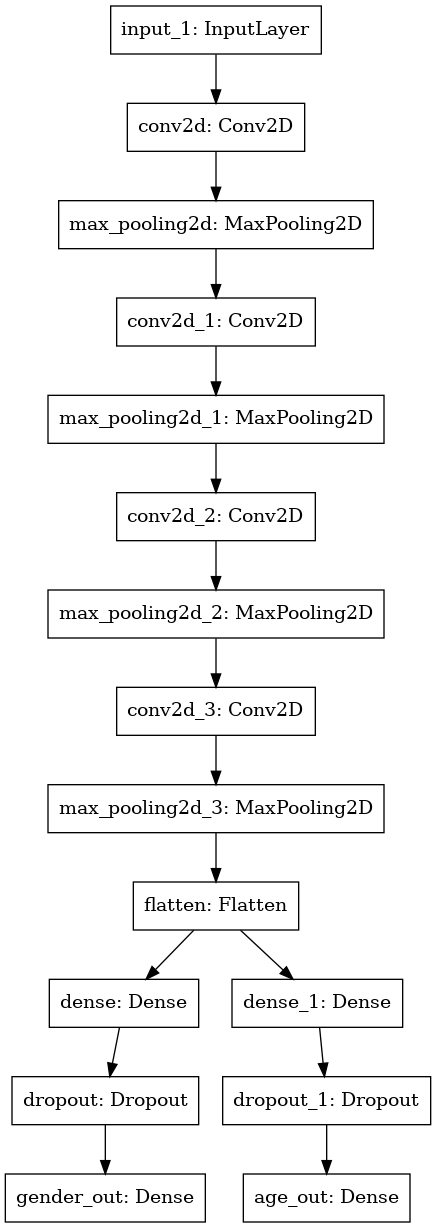

In [25]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [26]:
# train model
history = model.fit(x=x, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

2023-01-29 14:46:16.369231: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
593/593 [==============================] - 274s 460ms/step - loss: 15.6527 - gender_out_loss: 0.6757 - age_out_loss: 14.9770 - gender_out_accuracy: 0.5641 - age_out_accuracy: 0.0471 - val_loss: 12.2936 - val_gender_out_loss: 0.5521 - val_age_out_loss: 11.7415 - val_gender_out_accuracy: 0.7126 - val_age_out_accuracy: 0.0418
Epoch 2/30
593/593 [==============================] - 269s 454ms/step - loss: 11.5794 - gender_out_loss: 0.4855 - age_out_loss: 11.0940 - gender_out_accuracy: 0.7692 - age_out_accuracy: 0.0268 - val_loss: 10.1914 - val_gender_out_loss: 0.4189 - val_age_out_loss: 9.7725 - val_gender_out_accuracy: 0.8125 - val_age_out_accuracy: 0.0202
Epoch 3/30
593/593 [==============================] - 267s 450ms/step - loss: 10.0535 - gender_out_loss: 0.4230 - age_out_loss: 9.6305 - gender_out_accuracy: 0.7993 - age_out_accuracy: 0.0138 - val_loss: 9.4973 - val_gender_out_loss: 0.3844 - val_age_out_loss: 9.1129 - val_gender_out_accuracy: 0.8220 - val_age_out_accuracy: 0.0

 **Plotting Results**

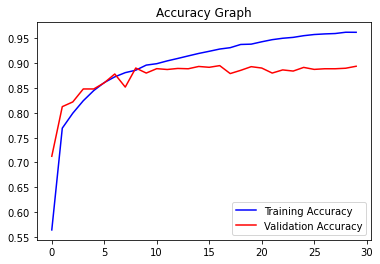

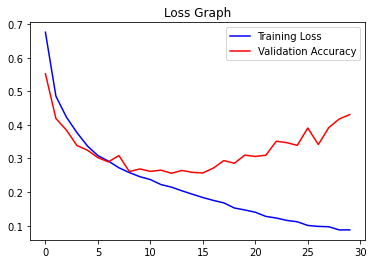

In [27]:
#Plotting results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']


plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Accuracy')
plt.title('Loss Graph')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

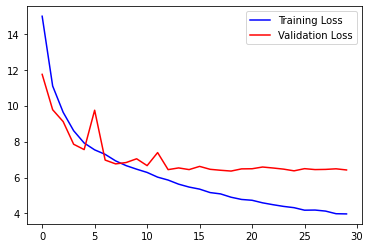

<Figure size 432x288 with 0 Axes>

In [28]:
# Plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.legend()
plt.figure()

**Prediction with test data**

Original Gender: Male    Original Age: 25
Predicted Gender:  Male    Predicted Age:  27


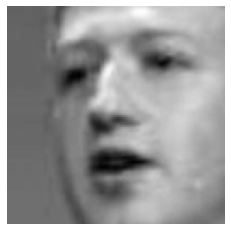

In [29]:
img_index = 1999
print("Original Gender:", gender_dict[y_gender[img_index]], "   Original Age:", y_age[img_index])
# Predict from model
pred = model.predict(x[img_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "   Predicted Age: ", pred_age)
plt.axis('off')
plt.imshow(x[img_index].reshape(128, 128), cmap='gray');